# ODE para crecimiento sublineal
lo siguiente es el sistema de crecimiento $$\dot{x}=\frac{x}{\theta}(1-x^{\theta})$$
el cual separaremos segun $\theta$ cuando cosntruyamos los procesos estocasticos correspondientes. Para $\theta>0$,podemos escribir
$$
\dot{x}=\frac{x}{\theta}-\frac{x^{1+\theta}}{\theta}
$$
para $\theta=0$ como
$$
\dot{x}=x|\log (x)| \mathbb{1}_{x<1}-x|\log (x)| \mathbb{1}_{x>1},
$$
y para $\theta< 0$ como
$$
\dot{x}=\frac{x^{1+\theta}}{|\theta|}-\frac{x}{|\theta|} .
$$

Consideraremos $t=0$ y que $x_0=n_0/K > 0$, donde K es la capacidad de carga del sistema y $n_0$ como poblacion inicial. En lo siguiente calcularemos las soluciones numericas para el sistema inicial, los cuales mediante variaciones del parametro $\theta$ serán soluciones de las 3 ecuaciones deducidas.

In [1]:
# --- 1. COMPUTACIÓN DE ALTO RENDIMIENTO (HPC) ---
import cupy as cp  # Librería para aceleración en GPU (backend compatible con NumPy)
import time        # Medición de tiempos de ejecución (benchmarking)

# --- 2. CÁLCULO NUMÉRICO Y MATEMÁTICO ---
import numpy as np              # Manejo de arrays y operaciones matemáticas en CPU
import scipy as sp              # Herramientas científicas avanzadas
from scipy.integrate import solve_ivp  # Solver robusto para ecuaciones diferenciales ordinarias (ODEs)

# --- 3. VISUALIZACIÓN ---
import matplotlib.pyplot as plt # Librería estándar para graficar resultados

# Funciones Utilizadas


## Modelo Sublineal

In [2]:
def deterministic_growth(t, x, theta):
    """
    Define la EDO del sistema: dx/dt.
    Maneja automáticamente la bifurcación entre modelos (Logístico, Gompertz, Sub/Superlineal).

    Args:
        theta (float): Parámetro de crecimiento. Si theta -> 0, usa el límite Gompertz.
    """
    # Caso Gompertz (theta aproximado a 0)
    if np.isclose(theta, 0):
        return x * np.log(1/x)

    # Caso General: Sublineal (theta < 0), Logístico (theta = 1), Superlineal (0 < theta != 1)
    return (x * (1 - x**theta)) / theta

def solve_deterministic_scenarios(t_eval, x0, scenarios):
    """
    Resuelve numéricamente los escenarios solicitados en batch.

    Args:
        scenarios (dict): Diccionario {nombre: valor_theta}
    Returns:
        dict: Soluciones de 'solve_ivp' indexadas por nombre.
    """
    solutions = {}
    for name, theta in scenarios.items():
        sol = solve_ivp(
            deterministic_growth,
            t_span=(0, max(t_eval)),
            y0=[x0],
            t_eval=t_eval,
            args=(theta,)
        )
        solutions[name] = sol
    return solutions

## Trayectoria del proceso de B&D
Nuestra intencion consiste en entender el comportamiento poblacional sublineal bajo la consideracion de procesos estocasticos y como la extincion depende fuertemente de algun parametro $\theta$

In [3]:
# --- FUNCIONES DE TASAS ESTOCÁSTICAS (JUMP RATES) ---
# Se elimina la redundancia. Alpha controla el ruido ambiental; por defecto es 0.

def birth_rate(x, theta, alpha=0):
    """ Tasa de nacimiento b(x) unificada. """
    if theta > 0:
        return (x/theta) + (alpha * x)
    elif theta < 0:
        return ((x**(1+theta)) / abs(theta)) + (alpha * x)
    else: # Caso Gompertz (theta=0)
        return (x * abs(np.log(x))) + (alpha * x) # Asumiendo log(x) contribution

def death_rate(x, theta, alpha=0):
    """ Tasa de muerte d(x) unificada. """
    if theta > 0:
        return ((x**(1+theta))/theta) + (alpha * x)
    elif theta < 0:
        return (x/abs(theta)) + (alpha * x)
    else: # Caso Gompertz (theta=0)
        return (x * abs(np.log(x))) + (alpha * x)

Una constrruccion inicial consistirá en tomar la suma de los parametros en el tiempo exponencial, al final de ese periodo tomamos la decicion de nacimiento con proba $b(n/K)((b(n/K)+d(n/K))$ y con proba complementaria la decision de muerte.

In [4]:
def simuladorTrayectoriasRuidosas(x0, T, K, theta, alpha, b_func, d_func):
    """
    Simula una trayectoria estocástica utilizando el método de Gillespie.

    Args:
        x0 (float): Densidad inicial.
        T (float): Horizonte de tiempo.
        K (int): Capacidad del sistema.
        theta (float): Parámetro theta.
        alpha (int): Parametro de ruido.
        b_func (function): Función de tasa de nacimiento.
        d_func (function): Función de tasa de muerte.

    Returns:
        list: Lista de tuplas (tiempo, valor de densidad) que representan la trayectoria.
    """
    val = x0
    tray = [(0, val)]
    t0 = 0

    while t0 < T:
        if val <= 0:
            tray.append((t0, val))
            break

        tasaB = K * b_func(val, theta, alpha)
        tasaD = K * d_func(val, theta, alpha)
        tasa_total = tasaB + tasaD

        if tasa_total <= 0:  # Avoid infinite loop if rates are zero or negative
            tray.append((t0, val))
            break

        # generamos el tiempo exponencial para el siguiente evento
        dt = np.random.exponential(scale=1 / tasa_total)

        # determinamos el evento siguiente basado en la probabilidad
        if np.random.rand() < tasaB / tasa_total:
            val += 1 / K  # Nacimiento
        else:
            val -= 1 / K  # Muerte

        t0 += dt
        tray.append((t0, val))

    return tray

## Visualizaciones

In [5]:
def plot_simulation_results(t_eval, deterministic_sols, stochastic_trajectories=None, title="Dinámica Poblacional"):
    """
    Visualiza las curvas deterministas y (opcionalmente) las trayectorias estocásticas.

    Args:
        t_eval (array): Vector de tiempo.
        deterministic_sols (dict): Salida de 'solve_deterministic_scenarios'.
        stochastic_trajectories (list/array, opcional): Trayectorias de la simulación Gillespie/Euler.
    """
    plt.figure(figsize=(12, 6))

    # 1. Plotear soluciones deterministas (Teóricas)
    colors = ['blue', 'green', 'red', 'purple']
    for (name, sol), color in zip(deterministic_sols.items(), colors):
        plt.plot(sol.t, sol.y[0], label=f'Teórico: {name}', linewidth=2, linestyle='--', color=color)

    # 2. Plotear trayectoria estocástica (Simulación) si existe
    if stochastic_trajectories is not None:
        # Check if stochastic_trajectories is a list of (time, value) tuples
        if isinstance(stochastic_trajectories, list) and all(isinstance(i, tuple) and len(i) == 2 for i in stochastic_trajectories):
            # Extract time and value components for step plot
            stoch_times = [point[0] for point in stochastic_trajectories]
            stoch_values = [point[1] for point in stochastic_trajectories]
            plt.step(stoch_times, stoch_values, label='Simulación Estocástica',
                     alpha=0.6, color='black', linewidth=1, where='post')
        else:
            # Assume it's a 1D array of values corresponding to t_eval
            plt.plot(t_eval, stochastic_trajectories, label='Simulación Estocástica',
                     alpha=0.6, color='black', linewidth=1)

    plt.title(title, fontsize=14)
    plt.xlabel("Tiempo", fontsize=12)
    plt.ylabel("Población (x)", fontsize=12)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## Convergencia de la Trayectoria

In [6]:
#calculo de la norma infinito para comparar soluciones
#numericas y aprox estocastica
def normaInft(trajectory1, trajectory2_t, trajectory2_y):
    t1, y1 = np.array(trajectory1).T
    t2, y2 = trajectory2_t, trajectory2_y

    # Haremos una interpolacion entre los puntos segun el tiempo
    # luego calculamos la distancia entre estos puntos y obtenemos el
    # maximo de estas diferencias
    y2_interp = np.interp(t1, t2, y2)
    diff = np.abs(y1 - y2_interp)
    linf_norm = np.max(diff)

    return linf_norm

# Experimentos

In [7]:
# Parametros de Simulacion
T = 20
dt = np.linspace(0,T,10*T)
K = 10000                         #capacidad del sistema
x0 = 1/K                          #densidad inicial
scenarios_params = {
    "Logístico (Theta=1)": 1,
    "Sublineal (Theta=-0.64)": -0.64,
    "Superlineal (Theta=0.64)": 0.64,
    "Gompertz (Theta=0)": 0
}

## Busqueda de soluciones de las ODE para cada caso

In [8]:
# x0 y t deben estar definidos previamente en tu notebook
det_solutions = solve_deterministic_scenarios(dt, x0, scenarios_params)

## Simulacion del proceso $Z_t^{K}$ de nacimiento y muerte

In [9]:
alpha = 0
tt_stch = scenarios_params["Sublineal (Theta=-0.64)"] # Selecting a specific theta value
trayectoria = simuladorTrayectoriasRuidosas(x0, T, K, tt_stch, alpha, birth_rate, death_rate)

## Visualizacion de soluciones y Convergencia

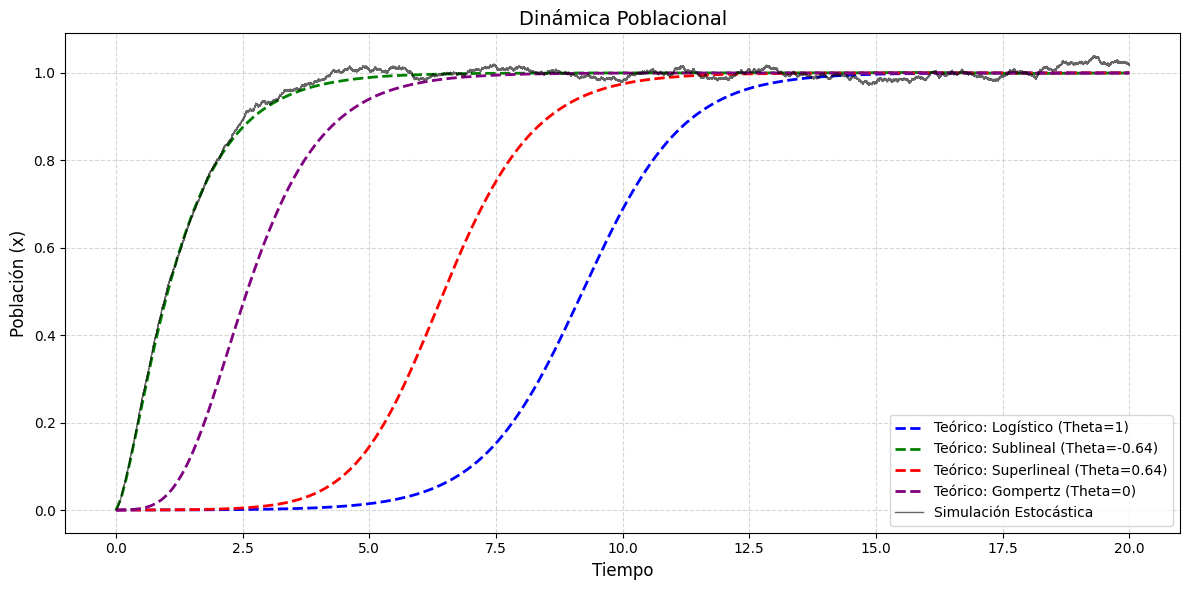

In [10]:
plot_simulation_results(dt, det_solutions, trayectoria)

Algunas observaciones al respecto de las soluciones son:
- Notemos que la solucion para el sistema inicial existe y es unica para cualquier condicion inicial real.
- Existen dos puntos de equilibrio, $0\text{ y }1$, donde se alcanza estabilidad en este ultimo punto.

Podemos notar que nuestra trayectoria estocastica aproxima las soluciones numericas encontradas, esto porque si calculamos la norma $L^{\infty}$ dentro del espacio de tiempo $[0,T]$ obtenemos que

In [11]:
# Extraemos la solución sublineal y su theta para la comparación de la norma
SG = det_solutions["Sublineal (Theta=-0.64)"]
thetaSG = scenarios_params["Sublineal (Theta=-0.64)"]

# invocamos la funcion de la norma inft y comparamos los valores numericos y
# estocasticos
convTSG = normaInft(trayectoria, SG.t, SG.y[0])

print(f"La norma L-infinit entre la tray. estocastica y la solucion numerica sublineal (theta={thetaSG}): {convTSG}")
print(f"El error de aproximacion viene a ser del : {convTSG*100:.5f}%")

La norma L-infinit entre la tray. estocastica y la solucion numerica sublineal (theta=-0.64): 0.03899273009724158
El error de aproximacion viene a ser del : 3.89927%


Lo cual es un indicador suficiente de que nuestra trayectoria corresponde a una solucion unica de las ecuaciones dependientes del parametro, segun la propos 1.1 del paper. Aunque es importante considerar que la disminucion de este valor depende del numero de epocas maximas que utilicemos y la capacidad de carga del sistema. Además, como nuestras construcciones son simulaciones del estilo Gilliespie el costo computacional crece a medida que las epocas aumentan. Aun asi, por infimo que parezca, el metodo alternativo presenta mejores aproximaciones por lo que lo mantendremos como el simulador de trayectorias

## Simulacion del proceso $Z_t^{K,α}$ de nacimiento y muerte
Este proceso analogo se construye a partir de una traslacion por una constante $α$, la añade eventos de nacimiento y muerte independientes de la densidad poblacional.


In [12]:
alpha = 5
tt_stch = scenarios_params["Sublineal (Theta=-0.64)"] # Selecting a specific theta value
trayectoria2 = simuladorTrayectoriasRuidosas(x0, T, K, tt_stch, alpha, birth_rate, death_rate)

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


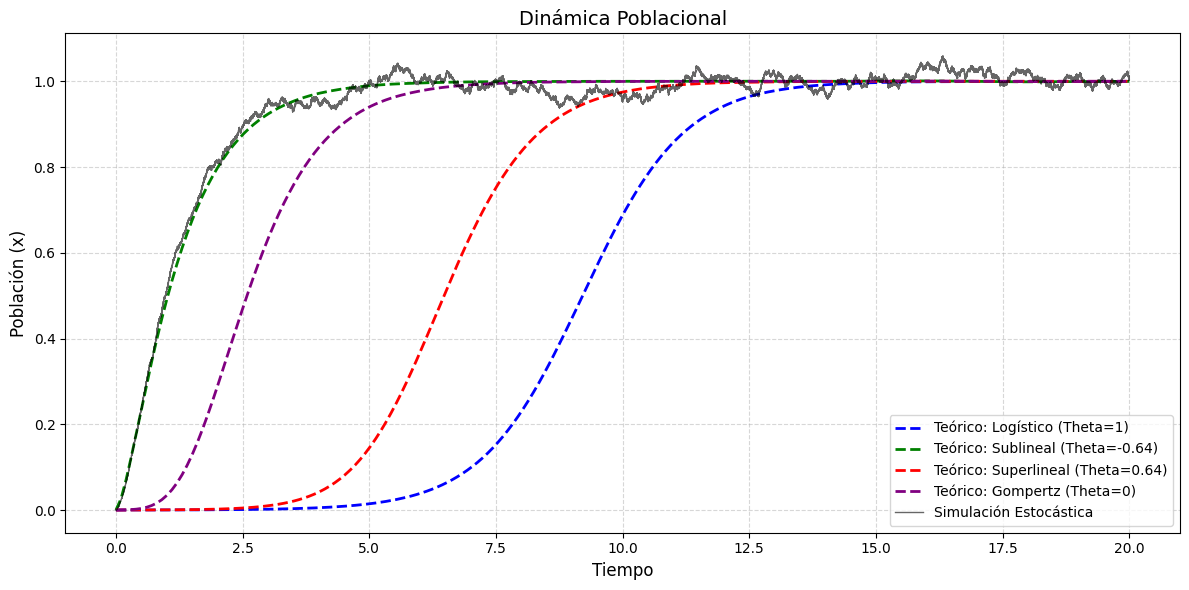

In [13]:
plot_simulation_results(dt, det_solutions, trayectoria2)

In [14]:
# Extraemos la solución sublineal y su theta para la comparación de la norma
SG = det_solutions["Sublineal (Theta=-0.64)"]
thetaSG = scenarios_params["Sublineal (Theta=-0.64)"]

# invocamos la funcion de la norma inft y comparamos los valores numericos y
# estocasticos
convTSG = normaInft(trayectoria2, SG.t, SG.y[0])

print(f"La norma L-infinit entre la tray. estocastica y la solucion numerica sublineal (theta={thetaSG}): {convTSG}")
print(f"El error de aproximacion viene a ser del : {convTSG*100:.5f}%")

La norma L-infinit entre la tray. estocastica y la solucion numerica sublineal (theta=-0.64): 0.06198885452273284
El error de aproximacion viene a ser del : 6.19889%


Podemos notar que este valor constante $\alpha$ entre mas alto es, más crece la diferencia entre esta trayectoria y la solucion numerica del modelo sublineal.

Otro punto interesante es el analisis del caso logistico, para el cual la extincion en un tiempo finito está asegurada para cualquier tamaño de poblacion inicial. Aunque, para poblaciones pequeñas, aun cuando el $0$ es un punto inestable, es posible ver la extincion ocurre rapidamente.